<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

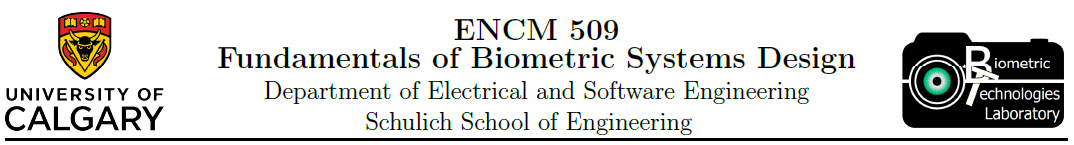

<center>
    <h1>Laboratory Experiment #4</h1>
    <h3>Fingerprint Biometrics - Part I: Preprocessing and Feature Extraction</h3>
</center>

In [1]:
import skimage
import os
import math
print('The scikit-skimage version is {}.'.format(skimage.__version__))

The scikit-skimage version is 0.18.3.


In [2]:
import cv2 as cv
import numpy as np

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, please open your Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median
from skimage.measure import find_contours

from scipy.signal.signaltools import wiener

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

/var/folders/hy/3zt6fpm52v137lbvptw6fkjr0000gp/T/ipykernel_89675/1188667198.py:14: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


### All the steps above compiled in one function

In [3]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    print('Total of minutiae detected: %d' % (len(minutiae_lst)))
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    print('Total of singularities detected: %d' % (len(singularities_lst)))
    
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
2. (10 marks) Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section).
3. Conclusion (a paragraph on what is the main take-out of the lab).

### Introduction

This lab is the first part of a 2 week fingerprint classification exercise. In this lab we will investigate different pre-processing techniques and how they contribute to feature extraction. By adding additional pre-processing steps or altering input parameters we will get familar with how each of these tehcniques operate. In the next lab we will use our pre-processed samples for classification models. 

**PART I: Specific Questions**

A detailed description of each exercise to be included in your report (10 marks total) is given below:

- **Exercise 1** (3 marks): Select **two fingerprints of different quality (one good and one bad one) from two different fingers each (4 in total)**. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) by adding the **histogram equalization** step. For each fingerprint, perform all the pre-processing, and then add the histogram equalization. Compare the quantity of minutiae and singularities detected WITHOUT and WITH  the histogram equalization step. Record the number of minutiae, the number of singularities for each case. Draw the conclusions from this comparison.

Text(0.5, 1.0, 'Left Pointer - Bad')

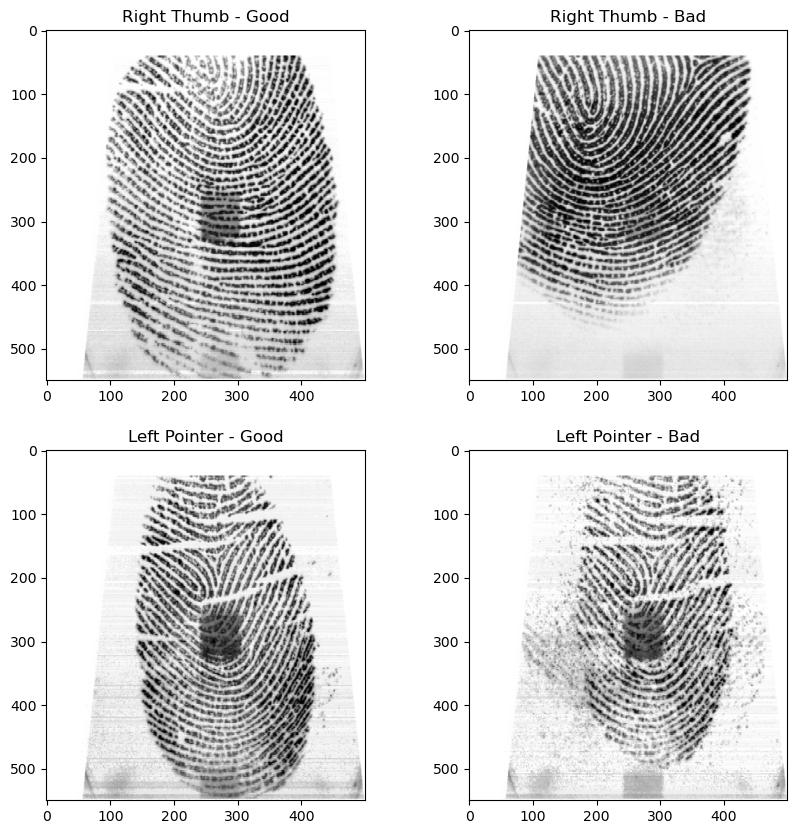

In [4]:
# Pick good and bad quality fingerprints and display images 

path = os.getcwd() + '/Data/'
r_good = img_as_ubyte(imread(path + 'Jess/8.bmp', as_gray=True))
r_bad = img_as_ubyte(imread(path + 'Jess/4.bmp', as_gray=True))

l_good = img_as_ubyte(imread(path + 'JessLeft/7.bmp', as_gray=True))
l_bad = img_as_ubyte(imread(path + 'JessLeft/1.bmp', as_gray=True))

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(r_good);
plt.title("Right Thumb - Good")
plt.subplot(222)
plt.imshow(r_bad);
plt.title("Right Thumb - Bad")

plt.subplot(223)
plt.imshow(l_good);
plt.title("Left Pointer - Good")
plt.subplot(224)
plt.imshow(l_bad);
plt.title("Left Pointer - Bad")

In [5]:
# Run processing and histogram equalization on each 

# parameters for processing
seg_threshold = 0.4
block_size = 16

# processing
print("Right Thumb - Good")
print("Processing ------------- ")
fingerprint_processing(r_good, block_size=block_size, threshold=seg_threshold)
print("Histogram Equilization ------------- ")
fingerprint_processing(img_as_ubyte(equalize_hist(r_good)), block_size=block_size, threshold=seg_threshold)
print("Adaptive Histogram Equilization ------------- ")
fingerprint_processing(img_as_ubyte(equalize_adapthist(r_good)), block_size=block_size, threshold=seg_threshold)
print("\n")

print("Right Thumb - Bad")
print("Processing ------------- ")
fingerprint_processing(r_bad, block_size=block_size, threshold=seg_threshold)
print("Histogram Equilization ------------- ")
fingerprint_processing(img_as_ubyte(equalize_hist(r_bad)), block_size=block_size, threshold=seg_threshold)
print("Adaptive Histogram Equilization ------------- ")
fingerprint_processing(img_as_ubyte(equalize_adapthist(r_bad)), block_size=block_size, threshold=seg_threshold)
print("\n")

print("Left Pointer - Good")
print("Processing ------------- ")
fingerprint_processing(l_good, block_size=block_size, threshold=seg_threshold)
print("Histogram Equilization ------------- ")
fingerprint_processing(img_as_ubyte(equalize_hist(l_good)), block_size=block_size, threshold=seg_threshold)
print("Adaptive Histogram Equilization ------------- ")
fingerprint_processing(img_as_ubyte(equalize_adapthist(l_good)), block_size=block_size, threshold=seg_threshold)
print("\n")

print("Left Pointer - Bad")
print("Processing ------------- ")
fingerprint_processing(l_bad, block_size=block_size, threshold=seg_threshold)
print("Histogram Equilization ------------- ")
fingerprint_processing(img_as_ubyte(equalize_hist(l_bad)), block_size=block_size, threshold=seg_threshold)
print("Adaptive Histogram Equilization ------------- ")
fingerprint_processing(img_as_ubyte(equalize_adapthist(l_bad)), block_size=block_size, threshold=seg_threshold)
print("\n")

Right Thumb - Good
Processing ------------- 
Total of minutiae detected: 62
Total of singularities detected: 2
Histogram Equilization ------------- 
Total of minutiae detected: 35
Total of singularities detected: 2
Adaptive Histogram Equilization ------------- 
Total of minutiae detected: 53
Total of singularities detected: 2


Right Thumb - Bad
Processing ------------- 
Total of minutiae detected: 59
Total of singularities detected: 4
Histogram Equilization ------------- 
Total of minutiae detected: 0
Total of singularities detected: 0
Adaptive Histogram Equilization ------------- 
Total of minutiae detected: 60
Total of singularities detected: 4


Left Pointer - Good
Processing ------------- 
Total of minutiae detected: 74
Total of singularities detected: 8
Histogram Equilization ------------- 
Total of minutiae detected: 27
Total of singularities detected: 4
Adaptive Histogram Equilization ------------- 
Total of minutiae detected: 83
Total of singularities detected: 8


Left Pointe

In every case, the histogram equilization detected less minutiae and the same number or fewer singularities compared to the unedited image. In contrast the adaptive histogram equilization detected the same number of singularities as the original image, and more minutiae in all fingers except the "Right Thumb - Good". The adapative histogram equilization outpreformed the regular histogram equilization for every finger, and outpreformed the unedited image in most cases.

From these results we can conclude that the adaptive histogram equilization technique produces the clearest results for this application. Since the "Right Thumb - Good" sample was already high quality, the equilization step did not enhance the image resulting in fewer features detected. 

- **Exercise 2** (3 marks): In this Exercise, perform the same steps as in exercise 1, but instead of histogram equalization, choose one **de-noising** method such as *Wiener* or *Median* filter. Modify the Lab notebook (`Lab04-Fingerprint1.ipynb`) accordingly, record the outcomes and draw the conclusions. 

In [8]:
# Run processing and histogram equilization on each 

# parameters for processing
seg_threshold = 0.4
block_size = 16

print("Right Thumb - Good")
print("Processing ------------- ")
fingerprint_processing(r_good, block_size=block_size, threshold=seg_threshold)
print("Wiener ------------- ")
img_wiener = wiener(r_good.astype('float'), (5,5))
img_wiener = img_as_ubyte((img_wiener-np.min(img_wiener))/(np.max(img_wiener)-np.min(img_wiener)))
fingerprint_processing(img_wiener, block_size=block_size, threshold=seg_threshold)
print("Median Filter ------------- ")
fingerprint_processing(median(r_good), block_size=block_size, threshold=seg_threshold)
print("\n")

print("Right Thumb - Bad")
print("Processing ------------- ")
fingerprint_processing(r_bad, block_size=block_size, threshold=seg_threshold)
print("Wiener ------------- ")
img_wiener = wiener(r_bad.astype('float'), (5,5))
img_wiener = img_as_ubyte((img_wiener-np.min(img_wiener))/(np.max(img_wiener)-np.min(img_wiener)))
fingerprint_processing(img_wiener, block_size=block_size, threshold=seg_threshold)
print("Median Filter ------------- ")
fingerprint_processing(median(r_bad), block_size=block_size, threshold=seg_threshold)
print("\n")

print("Left Pointer - Good")
print("Processing ------------- ")
fingerprint_processing(l_good, block_size=block_size, threshold=seg_threshold)
print("Wiener ------------- ")
img_wiener = wiener(l_good.astype('float'), (5,5))
img_wiener = img_as_ubyte((img_wiener-np.min(img_wiener))/(np.max(img_wiener)-np.min(img_wiener)))
fingerprint_processing(img_wiener, block_size=block_size, threshold=seg_threshold)
print("Median Filter ------------- ")
fingerprint_processing(median(l_good), block_size=block_size, threshold=seg_threshold)
print("\n")

print("Left Pointer - Bad")
print("Processing ------------- ")
fingerprint_processing(l_bad, block_size=block_size, threshold=seg_threshold)
print("Wiener ------------- ")
img_wiener = wiener(l_bad.astype('float'), (5,5))
img_wiener = img_as_ubyte((img_wiener-np.min(img_wiener))/(np.max(img_wiener)-np.min(img_wiener)))
fingerprint_processing(img_wiener, block_size=block_size, threshold=seg_threshold)
print("Median Filter ------------- ")
fingerprint_processing(median(l_bad), block_size=block_size, threshold=seg_threshold)
print("\n")

Right Thumb - Good
Processing ------------- 
Total of minutiae detected: 62
Total of singularities detected: 2
Wiener ------------- 
Total of minutiae detected: 39
Total of singularities detected: 0
Median Filter ------------- 
Total of minutiae detected: 44
Total of singularities detected: 2


Right Thumb - Bad
Processing ------------- 
Total of minutiae detected: 59
Total of singularities detected: 4
Wiener ------------- 
Total of minutiae detected: 44
Total of singularities detected: 4
Median Filter ------------- 
Total of minutiae detected: 61
Total of singularities detected: 4


Left Pointer - Good
Processing ------------- 
Total of minutiae detected: 74
Total of singularities detected: 8
Wiener ------------- 
Total of minutiae detected: 44
Total of singularities detected: 6
Median Filter ------------- 
Total of minutiae detected: 49
Total of singularities detected: 4


Left Pointer - Bad
Processing ------------- 
Total of minutiae detected: 124
Total of singularities detected: 8


The above results show the number of minuiae and singularities detected for the raw, wiener filtered and median filtered images. In nearly all cases the filtered images resulted in less minutiae and the same number or fewer singularities compared to the unfiltered images. The one exception to this is the median filtered Right Thumb - Bad which identified 2 more singularities compared to the uneditied image. The reason for fewer minutiae being indetinfied in the filtered images could be because filtering removes artifacts that are erronesouly being classified as minutiae.

The median filter detected more minutiae compared with the wiener filter. This suggests the wiener filter smooths the image more. This means with wiener filter is removing more noise, however this filter may also smooth acutal features too much that they aren't being detected anymore.

- **Exercise 3** (4 marks): In this exercise, perform the same steps as in Exercise 1, but consider the **parameters `block_size` and `threshold`**. Evaluate the impact of these parameters by changing each of them to another value one at a time, for example: **change the `block_size` to 10 (`block_size = 10`) and keep the `threshold = 0.4`** (default). Second, **change the threshold only to `threshold = 0.5` while keeping the `block_size = 16`** (default). Evaluate  the number  of the detected minutiae and singularities. Compare the results and draw the conclusions.  

In [7]:
# Changing paramaeters 

# parameters for processing
seg_threshold = 0.4
block_size = 16

threshold = [0.4, 0.8]
block_size = [16, 20]
finger = [r_good, r_bad, l_good, l_bad]
finger_text = ["Right Thumb - Good", "Right Thumb - Bad", "Left Pointer - Good", "Left Pointer - Bad"]

for f, txt in zip(finger, finger_text):
    print(txt)
    for t in threshold:
        for s in block_size:
            print("Threshold = ", t, "     Block Size = ", s)
            fingerprint_processing(f, block_size=s, threshold=t)
    print("\n")
        

Right Thumb - Good
Threshold =  0.4      Block Size =  16
Total of minutiae detected: 62
Total of singularities detected: 2
Threshold =  0.4      Block Size =  20
Total of minutiae detected: 58
Total of singularities detected: 2
Threshold =  0.8      Block Size =  16
Total of minutiae detected: 13
Total of singularities detected: 0
Threshold =  0.8      Block Size =  20
Total of minutiae detected: 42
Total of singularities detected: 0


Right Thumb - Bad
Threshold =  0.4      Block Size =  16
Total of minutiae detected: 59
Total of singularities detected: 4
Threshold =  0.4      Block Size =  20
Total of minutiae detected: 41
Total of singularities detected: 4
Threshold =  0.8      Block Size =  16
Total of minutiae detected: 32
Total of singularities detected: 0
Threshold =  0.8      Block Size =  20
Total of minutiae detected: 20
Total of singularities detected: 0


Left Pointer - Good
Threshold =  0.4      Block Size =  16
Total of minutiae detected: 74
Total of singularities detect

**Increasing threshold while keeping block size constant**  <br>
In all cases resulted in less minutiae and singularities being detected. 

**Increasing block size while keeping threshold constant** <br>
In most cases resulted in less minutiae and singularities being detected. <br><br>

Block size and threshold are used in several functions within fingerprint_processing(). In general increasing kernal size means you are preforming an operation over a larger area of pixels so the result will be more normalized. Therefore, it makes sense that fewer features are detected with increasing kernal size. Increasing threshold also results in fewer features because the model is more strict with identifying features. 

# Conclusion

In this lab we learned how to extract the basic features of a fingerprint. These features are includes Segmentation, Orientation estimation and Ridge orientation. We then applied Gabor filters to enhance the fingerprints to better extract the data points from the fingerprints. We found that properly preprocessing the prints can assist in getting the cleanest feature possible.

Next lab we will be adding on to this process and use fingerprint matching algorithms to help us identify the individuals fingerprints.